In [193]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [194]:
# returns the probabilities of the actions  
def boltzmann_exploration(qvalues, temperature):
    # `- np.max(qvalues)` is used to prevent nan values 
    exp = np.exp((qvalues - np.max(qvalues)) / temperature)
    return exp / np.sum(exp)

In [195]:
def pd(i: bool, j: bool):
    reward_table = [[(1, 1), (5, 0)], [(0, 5), (3, 3)]]
    return reward_table[int(i)][int(j)]

# Agent
Each agent has two Q-Tables, one for partner selection (ps) and one for prisoners dilemma (pd).

| Q-Table Indices | Defect(0) | Cooperate(1) |
| --- | --- | --- |
| Partner Previously Defected(0) | (0, 0) | (0, 1) |
| Partner Previously Cooperated(1) | (1, 0) | (1, 1) |

### Trajectories
Each agent tracks the folowing figures each round as a trajectory:
$$(s_{PS}, a_{PS}, s'_{PS} = s_{PD}, a_{PD}, s'_{PD}, r_{PD})$$

In [196]:
class Agent:
    def __init__(self, learning_rate: float, temperature: float, discount_rate: float):
        self.a = learning_rate
        self.t = temperature
        self.g = discount_rate
        self.last_action = bool(random.getrandbits(1))
        self.qvalues_ps = np.zeros((2, 2))
        self.qvalues_pd = np.zeros((2, 2))
        return

    # get action for partner selection
    # returns true if agent stays and false if agent breaks ties
    def get_action_ps(self, partner_la) -> bool:
        prob = boltzmann_exploration(self.qvalues_ps[int(partner_la)], self.t)
        return bool(np.random.choice(2, p=prob))

    # get action for the prisoner's dilemma
    # returns true if the agent cooperates and false if the agent defects
    def get_action_pd(self, partner_la) -> bool:
        prob = boltzmann_exploration(self.qvalues_pd[int(partner_la)], self.t)
        return bool(np.random.choice(2, p=prob))

    # trains the agent using the Q-Learning formula
    def train(self, trajectories):
        ps_qvalues = np.copy(self.qvalues_ps)
        pd_qvalues = np.copy(self.qvalues_pd)
        
        for t in trajectories:
            ps_qvalues[t[0], t[1]] = (1 - self.a) * self.qvalues_ps[t[0], t[1]] + self.a * (t[5] + self.g * np.max(self.qvalues_ps[t[2], :]))
            pd_qvalues[t[2], t[3]] = (1 - self.a) * self.qvalues_pd[t[2], t[3]] + self.a * (t[5] + self.g * np.max(self.qvalues_pd[t[4], :]))

        # for i in range(2):
        #     for j in range(2):
        #         if pd_qvalues[i, j] == 0:
        #             pd_qvalues[i, j] = self.qvalues_pd[i, j]
        #         if ps_qvalues[i, j] == 0:
        #             ps_qvalues[i, j] = self.qvalues_ps[i, j]

        # if np.min(ps_qvalues) == 0 or np.min(pd_qvalues) == 0:
        #     print()

        self.qvalues_ps = ps_qvalues
        self.qvalues_pd = pd_qvalues

In [197]:
def sdoo(population: int, rounds: int, episodes: int, learning_rate: float, temperature: float, discount_rate: float):
    agents = [Agent(learning_rate, temperature, discount_rate) for _ in range(population)]
    unpaired = list(range(population))
    
    num_outcomes = [[0 for _ in range(episodes)] for _ in range(4)]
    
    pairs = []
    while unpaired:
        i = unpaired.pop(np.random.randint(len(unpaired)))
        j = unpaired.pop(np.random.randint(len(unpaired)))
        pairs.append((i, j))
    
    for episode in range(episodes):
        trajectories = [[] for _ in range(population)]
        for round in range(rounds):
            it_pair = 0
            while it_pair < len(pairs):
                pair = pairs[it_pair]
                i = pair[0]
                j = pair[1]
                la_i = agents[i].last_action
                la_j = agents[j].last_action
                a_i = agents[i].get_action_ps(la_j)
                a_j = agents[j].get_action_ps(la_i)
                trajectories[i].append((int(la_j), int(a_i)))
                trajectories[j].append((int(la_i), int(a_j)))
                
                if not a_i or not a_j:
                    unpaired.append(i)
                    unpaired.append(j)
                    pairs.remove(pair)
                else:
                    it_pair += 1
                
            while unpaired:
                i = unpaired.pop(np.random.randint(len(unpaired)))
                j = unpaired.pop(np.random.randint(len(unpaired)))
                pairs.append((i, j))

            for pair in pairs:
                i = pair[0]
                j = pair[1]
                la_i = agents[i].last_action
                la_j = agents[j].last_action
                a_i = agents[i].get_action_pd(la_j)
                a_j = agents[j].get_action_pd(la_i)
                r_i, r_j = pd(a_i, a_j)
                
                num_outcomes[int(a_i) + 2 * int(a_j)][episode] += 1
    
                trajectories[i][round] = (trajectories[i][round][0], trajectories[i][round][1], int(la_j), int(a_i), int(a_j), float(r_i))
                trajectories[j][round] = (trajectories[j][round][0], trajectories[j][round][1], int(la_i), int(a_j), int(a_i), float(r_j))
                
                agents[i].last_action = a_i
                agents[j].last_action = a_j

        for idx, agent in enumerate(agents):
            agent.train(trajectories[idx])
            
    
    # num_games = population * rounds * episodes / 2
    # print("games: %i" % (num_games))
    # print("(D, D): %i\t%f%%" % (num_outcomes[0], 100 * num_outcomes[0] / num_games))
    # print("(C, D): %i\t%f%%" % (num_outcomes[1], 100 * num_outcomes[1] / num_games))
    # print("(D, C): %i\t%f%%" % (num_outcomes[2], 100 * num_outcomes[2] / num_games))
    # print("(C, C): %i\t%f%%" % (num_outcomes[3], 100 * num_outcomes[3] / num_games))

    plt.plot(num_outcomes[0], linewidth=1)
    plt.plot(num_outcomes[1], linewidth=1)
    plt.plot(num_outcomes[2], linewidth=1)
    plt.plot(num_outcomes[3], linewidth=1)
    
    plt.xlabel('Episode')
    plt.ylabel('Number of Outcomes')
    plt.ylim(0, population * rounds / 2)
    plt.legend(["(D, D)", "(C, D)", "(D, C)", "(C, C)"])

    plt.show()


    strategies = [
        # ("Random-PS", 0, np.array([[1, 1], [1, 1]])),
        ("Always-Stay", 0, np.array([[0, 1], [0, 1]])),
        ("Out-for-Tat", 0, np.array([[1, 0], [0, 1]])),
        ("Reverse-OFT", 0, np.array([[0, 1], [1, 0]])),
        ("Always-Switch", 0, np.array([[1, 0], [1, 0]])),
        # ("Random-PD", 1, np.array([[1, 1], [1, 1]])),
        ("Always-Cooperate", 1, np.array([[0, 1], [0, 1]])),
        ("Tit-for-Tat", 1, np.array([[1, 0], [0, 1]])),
        ("Reverse-TFT", 1, np.array([[0, 1], [1, 0]])),
        ("Always-Defect", 1, np.array([[1, 0], [1, 0]])),
    ]

    # TODO: switch strategy and agent loops for better performance
    for agent in agents:
        print()
        
        temp = agent.qvalues_ps
        # temp = np.array([boltzmann_exploration(temp[0], temperature), boltzmann_exploration(temp[1], temperature)])
        print(temp)
        temp = agent.qvalues_pd
        # temp = np.array([boltzmann_exploration(temp[0], temperature), boltzmann_exploration(temp[1], temperature)])
        print(temp)

        angles = [[], []]
        for strategy in strategies:
            mat = agent.qvalues_pd if strategy[1] == 1 else agent.qvalues_ps
            # mat = np.array([boltzmann_exploration(mat[0], temperature), boltzmann_exploration(mat[1], temperature)])
            # print(mat)
            mat2 = strategy[2]
            norm = np.linalg.norm(mat)
            strategy_norm = np.linalg.norm(mat2)
            elm = np.multiply(mat, mat2)
            prod = np.sum(elm)
            angle = np.rad2deg(np.arccos(prod / (norm * strategy_norm)))
            angles[strategy[1]].append(angle)
        
        min_ps = np.argmin(angles[0])
        min_pd = np.argmin(angles[1])
        print("PS-Strategy = %s (%9fdeg)\t\tPD-Strategy = %s (%9fdeg)" % (strategies[min_ps][0], angles[0][min_ps], strategies[min_pd + len(angles[0])][0], angles[1][min_pd]))

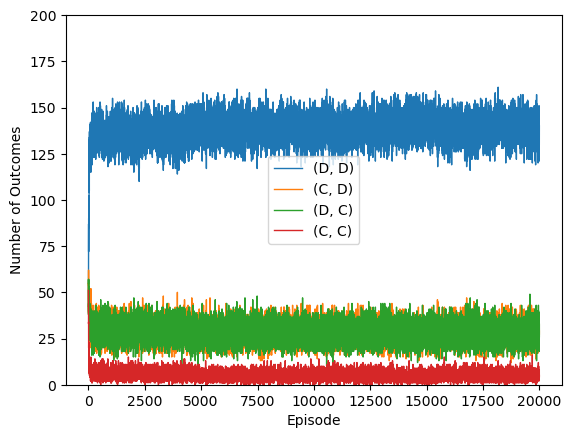


[[1676.08924493 1675.71609906]
 [1675.03327553   48.55306954]]
[[1643.43948849 1642.58432804]
 [1643.49917437    2.15625641]]
PS-Strategy = Always-Switch (35.278222deg)		PD-Strategy = Always-Defect (35.249866deg)

[[1688.64094068 1689.8072487 ]
 [1688.26726407   42.94941006]]
[[1673.49038252 1671.97110393]
 [1673.1530213     3.60679898]]
PS-Strategy = Reverse-OFT (35.266791deg)		PD-Strategy = Always-Defect (35.242647deg)

[[1703.09191221 1703.76739492]
 [1701.79222344   21.66053915]]
[[1662.90663924 1661.27623448]
 [1663.13124217    3.21719696]]
PS-Strategy = Reverse-OFT (35.271534deg)		PD-Strategy = Always-Defect (35.236127deg)

[[1690.04922449 1690.53126263]
 [1689.4320645    22.7822155 ]]
[[1651.67234799 1650.03476026]
 [1651.44438331    5.2791961 ]]
PS-Strategy = Reverse-OFT (35.267926deg)		PD-Strategy = Always-Defect (35.239603deg)

[[1688.56515065 1688.57477821]
 [1687.85642663   16.39543749]]
[[1653.85998853 1652.29997549]
 [1653.64751042    3.77937602]]
PS-Strategy = Reverse-O

In [199]:
sdoo(20, 20, 20000, 0.05, 1, 1)